In [56]:
import pickle
import torch.utils.data
import torch
from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd


load_path = './data/cartpole4/env4_1'

KeyError: 'ep_path_tensor'

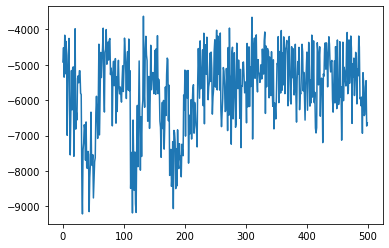

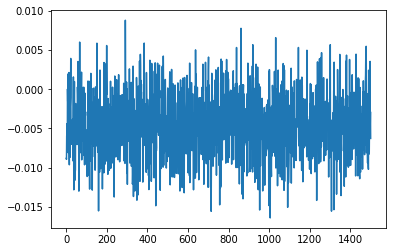

<Figure size 432x288 with 0 Axes>

In [60]:
model, env, args, ws = load_workspace(load_path)
plt.plot(ws['avg_reward_hist'])
print
plt.figure()
plt.plot(np.array(ws['ep_action_tensor']))
model.action_var
plt.figure()
plt.plot(np.array(ws['ep_path_tensor']))

In [40]:
model, env = load_model(load_path)
data = pd.read_csv(load_path + '/progress.csv')
plt.plot(data['eprewmean'])


KeyError: 'save_path'

1499
[855.39908061]


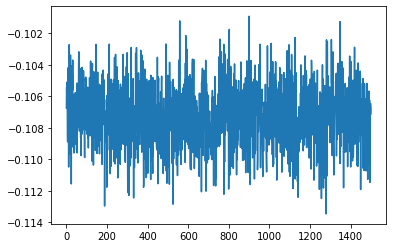

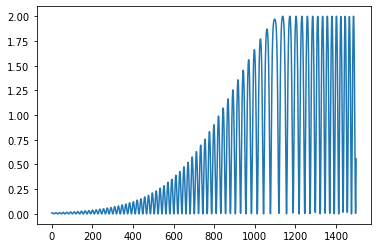

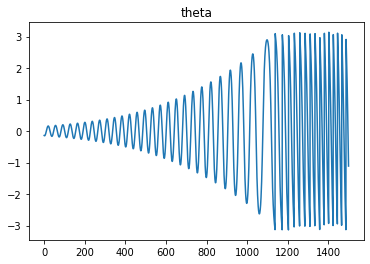

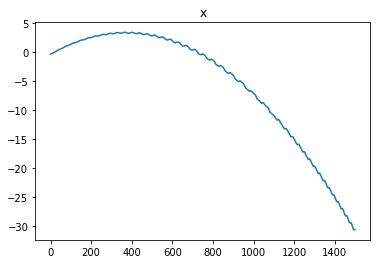

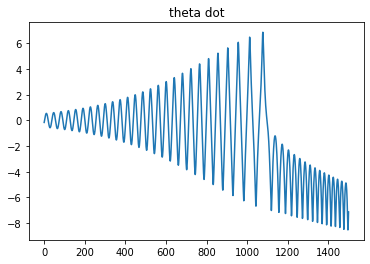

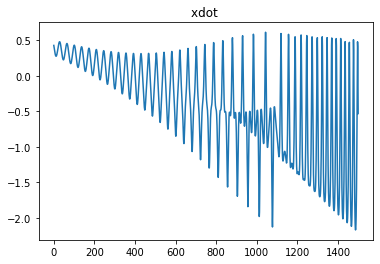

In [59]:
myenv = env
myenv.num_steps=1500

action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

obs = env.reset()
model.hyst_state = 0

for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("x")


plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta dot")


plt.figure()
plt.plot(state_hist[:,3])
plt.title("xdot ")



print(i)
print(sum(reward_hist))

In [ ]:
actions, _, _, _ = model.step(obs)
obs, reward, done, _ = env.step(actions)        
env.render()
print(reward)

In [ ]:
env.state[0] = np.pi
env.state[1] = 1
env.render()

In [ ]:
-(np.cos(env.state[0]) + np.cos(env.state[0] + env.state[1]))

In [ ]:
np.cos(env.state[0])

In [ ]:
np.cos(env.state[1])

In [ ]:
env.action_space.high

In [ ]:
pprint(list(ws.keys()))

In [ ]:
action_hist

In [ ]:
model.policy.state_dict()